In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='data',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.CIFAR10(root='data',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import pickle
with open('data/cifar-10-batches-py/batches.meta', 'rb') as file:
    label_name = pickle.load(file, encoding='bytes')[b'label_names']
# label_name

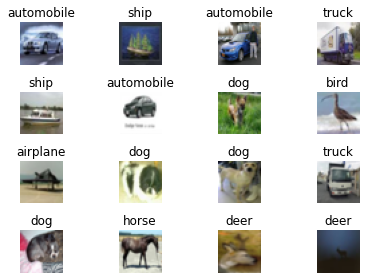

In [6]:
n = 4
fig = plt.figure()
for i in range(n * n):
    index = torch.randint(0, len(train_dataset), size=(1, )).item()
    img, label = train_dataset[index]
    fig.add_subplot(n, n, i + 1)
    plt.title(label_name[label].decode('utf-8'))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()

# VGGNet
![VGGNet](https://pytorch.org/assets/images/vgg.png)
![vgg11](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png)

In [7]:
def VGG_block(count, in_channel, out_channel):
    block = []
    for i in range(count):
        block.append(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))
        block.append(nn.ReLU())
        in_channel = out_channel
    return nn.Sequential(*block, nn.MaxPool2d(kernel_size=2, stride=2))

In [8]:
# VGG16_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
VGG11_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

in_channel = 3
blocks = []

for (count, out_channel) in VGG11_arch:
    blocks.append(VGG_block(count, in_channel, out_channel))
    in_channel = out_channel

blocks_out_channel = VGG11_arch[-1][1] * (32 // 2 ** len(VGG11_arch)) ** 2
VGG11Net = nn.Sequential(
    *blocks, nn.Flatten(),
    nn.Linear(blocks_out_channel, 4096), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(4096, 10),
)

print(f'on: {device}')
VGG11Net.to(device)

on: cuda


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [10]:
sample = torch.randn(size=(1, 3, 32, 32)).to(device)
for block in VGG11Net:
    sample = block(sample)
    print(block.__class__.__name__, '   \t gives:', sample.shape)

Sequential    	 gives: torch.Size([1, 64, 16, 16])
Sequential    	 gives: torch.Size([1, 128, 8, 8])
Sequential    	 gives: torch.Size([1, 256, 4, 4])
Sequential    	 gives: torch.Size([1, 512, 2, 2])
Sequential    	 gives: torch.Size([1, 512, 1, 1])
Flatten    	 gives: torch.Size([1, 512])
Linear    	 gives: torch.Size([1, 4096])
ReLU    	 gives: torch.Size([1, 4096])
Dropout    	 gives: torch.Size([1, 4096])
Linear    	 gives: torch.Size([1, 4096])
ReLU    	 gives: torch.Size([1, 4096])
Dropout    	 gives: torch.Size([1, 4096])
Linear    	 gives: torch.Size([1, 10])


In [14]:
def init_weight(x):
    if isinstance(x, nn.Linear) or isinstance(x, nn.Conv2d):
        nn.init.kaiming_uniform_(x.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(x.bias)
        # x.bias.zero_()

if input('load stored model? [y/n]') == 'y':
    VGG11Net.load_state_dict(torch.load('VGG11Net.pth'))
else:
    VGG11Net.apply(init_weight)
VGG11Net.train()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [11]:
from tqdm.notebook import tqdm, trange

num_epoch = 60

lr = .01
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(VGG11Net.parameters(), lr=lr, weight_decay=2e-3)

def accuracy(dataloader, model):
    hit, total = 0, 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            y_hat = VGG11Net(x).softmax(dim=1).argmax(dim=1)
            hit += (y_hat == y).sum()
            total += y.size(0)
        return hit / total

x_epoch, y_loss, y_acctrain, y_acctest = [], [], [], []

for epoch in tqdm(range(num_epoch), desc='epoches'):
    VGG11Net.train()
    ls = []
    for x, y in tqdm(train_loader, desc='batches'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = VGG11Net(x).softmax(dim=1)
        # print(y_hat.shape, y_hat)
        l = loss(y_hat, y)
        l.backward()
        ls.append(l)
        optimizer.step()

    x_epoch.append(epoch + 1)
    y_loss.append(torch.tensor(ls).mean())
    y_acctest.append(accuracy(test_loader, VGG11Net))
    y_acctrain.append(accuracy(train_loader, VGG11Net))

    torch.save(VGG11Net.state_dict(), 'VGG11Net.pth')

x_epoch, y_loss, y_acctrain, y_acctest = torch.tensor([x_epoch, y_loss, y_acctrain, y_acctest])

import requests
requests.get('https://maker.ifttt.com/trigger/model_down/with/key/c4J6dG9XEDH4pEFnecPmMk')

epoches: 0it [00:00, ?it/s]

<Response [200]>

(0.0, 1.0)

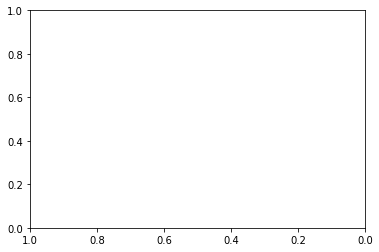

In [12]:
plt.plot(x_epoch, y_loss, '.', label='loss')
plt.plot(x_epoch, y_acctest, 'r-', label='test acc')
plt.plot(x_epoch, y_acctrain, 'g-', label='train acc')
plt.xlim(1,num_epoch)
plt.ylim(0,1)

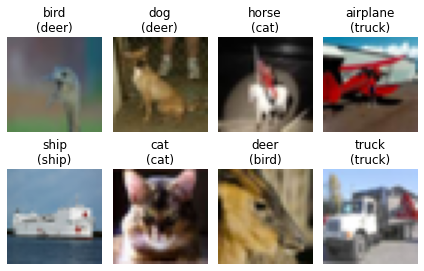

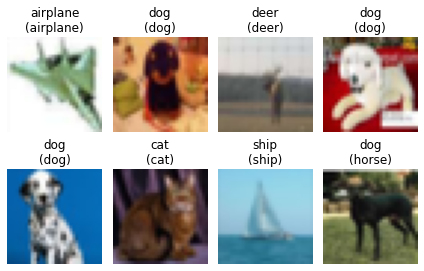

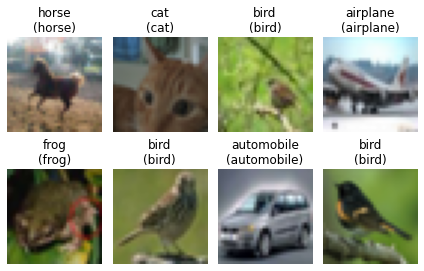

In [21]:
n,m = 2,4
for _ in range(3): # no. images
    fig = plt.figure()
    for i in range(n * m):
        index = torch.randint(0, len(test_dataset), size=(1, )).item()
        img, label = test_dataset[index]
        fig.add_subplot(n, m, i + 1)
        pred = VGG11Net(img.to(device).reshape(1,3,32,32)).softmax(dim=1).argmax(dim=1)
        tolb = lambda l : label_name[l].decode('utf-8')
        plt.title(tolb(label) + '\n' + f'({tolb(pred)})')
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()